# 9.7.2 Renewable Resource Management

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 9.7.4

資源ストック（木材、漁業資源のようなもの）$s$のうち$x$を収穫し、それを売却し利益を得る。  
収穫コストは$c(x)$、価格は$p(x)$。  
$t+1$期のsは$s_{t+1}=h(s_{t}-x_{t})$

state variable $s\in[0,s)$  
action variable $x\in[0,s]$  
state transaction function $g(s,x)=h(s-x)$  
reward function $f(s,x)=\int_0^x p(\xi) d\xi-c(x)$  
Bellman equation $V(s)=max_{0\leq x\leq s} \{\int_0^x p(\xi) d\xi-c(x)+\delta V(h(s-x))\} $

今回の例では  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2$  
$p(x)=x^{-\gamma}$  
$f(s,x) =  \int_0^x p(\xi) d\xi-c(x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x$

In [1]:
using QuantEcon
using BasisMatrices
using Plots
using Optim

In [2]:
struct RenewableResourceManagement
    alpha::Float64
    beta::Float64
    gamma::Float64
    kappa::Float64
    delta::Float64
    s_vec::Vector{Float64}
end

In [3]:
n = 500
smin = 0
smax = 10
fspace = Basis(ChebParams(n,smin,smax))
snodes = nodes(fspace)

([2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998], Array{Float64,1}[[2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998]])

In [4]:
rrm = RenewableResourceManagement(4.0,1.0,0.5,0.2,0.9,snodes[1])

RenewableResourceManagement(4.0, 1.0, 0.5, 0.2, 0.9, [2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998])

初期の方（授業で直す前のもの、update_bellmanの中のV_funcが線型補間）

In [5]:
function update_bellman(RRM::RenewableResourceManagement,V::Vector)
    a,b,g,k,d = RRM.alpha, RRM.beta, RRM.gamma, RRM.kappa, RRM.delta
    V_func = LinInterp(RRM.s_vec, V)
    V_new = similar(V)
    policy = similar(V)
    
    for (i, s) in enumerate(RRM.s_vec)
        objective(x) =  -((x^(1-g))/(1-g) -k*x +d*(V_func.(a*(s-x)-0.5*b*(s-x)^2)))
        opt = optimize(objective,1e-10,s)
        V_new[i] = -opt.minimum
        policy[i] = opt.minimizer
    end
    return V_new,policy
end

update_bellman (generic function with 1 method)

In [6]:
V = Vector{Float64}(length(rrm.s_vec))
for i in 1:length(rrm.s_vec)
    V[i] = 6
end

In [7]:
V_comp = similar(V)
policy = similar(V)
tol = sqrt(eps())
max_iter = 1000
V_error = 1.0
i = 1
while V_error > tol && i <= max_iter
    V_comp ,policy = update_bellman(rrm,V)
    V_error = maximum(abs, V_comp - V) 
    copy!(V,V_comp)
    i += 1
end


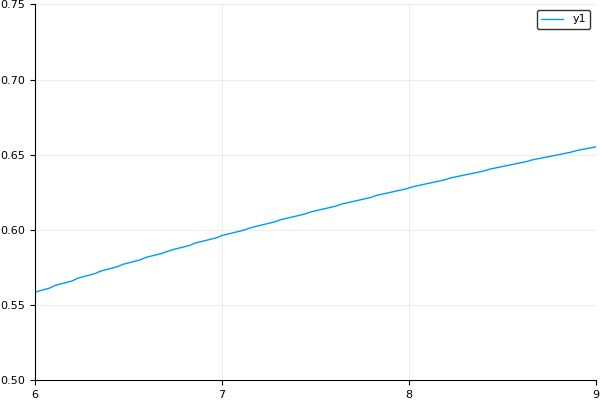

In [8]:
plot(rrm.s_vec,policy./rrm.s_vec,xlim = (6,9),ylim=(0.5,0.75))


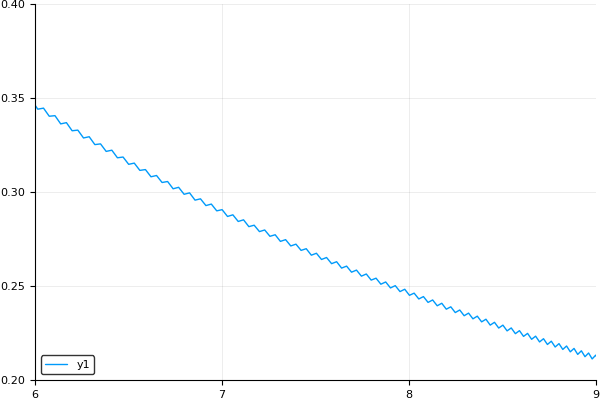

In [9]:
Phi = BasisMatrix(fspace, Expanded(), rrm.s_vec, 0)
coef = Phi.vals[1] \ V
order = 1
B1 = evalbase(fspace.params[1], rrm.s_vec, order) #Vをチェビシェフ補間したやつを一回微分
interp1 = B1 * coef
plot(rrm.s_vec, interp1, xlim = (6,9),ylim=(0.2,0.4))

授業で訂正した方（update_bellmanの中のVがチェビシェフ補間）

In [10]:
function update_bellman(RRM::RenewableResourceManagement,V::Vector)
    a,b,g,k,d = RRM.alpha, RRM.beta, RRM.gamma, RRM.kappa, RRM.delta
    V_new = similar(V)
    policy = similar(V)
    basis = Basis(ChebParams(n, smin, smax))
    p_vec,_ = nodes(basis)
    Φ = BasisMatrix(basis, Expanded(), p_vec, 0)
    coeffs_V = Φ.vals[1] \ V
    
    for (i, s) in enumerate(RRM.s_vec)        
        objective(x) =  -((x^(1-g))/(1-g) -k*x +d*funeval(coeffs_V, basis, a*(s-x)-0.5*b*(s-x)^2))
        opt = optimize(objective,1e-10,s)
        V_new[i] = -opt.minimum
        policy[i] = opt.minimizer
    end
    return V_new,policy
end

update_bellman (generic function with 1 method)

In [11]:
V = Vector{Float64}(length(rrm.s_vec))
for i in 1:length(rrm.s_vec)
    V[i] = 6
end

In [12]:
V_comp = similar(V)
policy = similar(V)
tol = sqrt(eps())
max_iter = 500
V_error = 1.0
i = 1
while V_error > tol && i <= max_iter
    V_comp ,policy = update_bellman(rrm,V)
    V_error = maximum(abs, V_comp - V) 
    copy!(V,V_comp)
    i += 1
end

In [13]:
i

183

In [14]:
V_error

1.394468718274311e-8

In [15]:
policy

500-element Array{Float64,1}:
 3.32953e-10
 3.26901e-8 
 2.29397e-7 
 8.08966e-7 
 2.0644e-6  
 4.34682e-6 
 8.08703e-6 
 1.37524e-5 
 2.18843e-5 
 3.3047e-5  
 4.78176e-5 
 6.69923e-5 
 9.13475e-5 
 ⋮          
 6.77924    
 6.78121    
 6.78301    
 6.78462    
 6.78606    
 6.78731    
 6.78839    
 6.78929    
 6.79001    
 6.79054    
 6.7909     
 6.79108    

In [16]:
V

500-element Array{Float64,1}:
 12.6283
 15.3703
 16.6524
 17.5377
 18.2252
 18.7918
 19.2762
 19.7007
 20.0793
 20.4216
 20.7344
 21.0229
 21.2907
  ⋮     
 33.9926
 33.993 
 33.9934
 33.9937
 33.994 
 33.9942
 33.9944
 33.9946
 33.9948
 33.9949
 33.9949
 33.995 


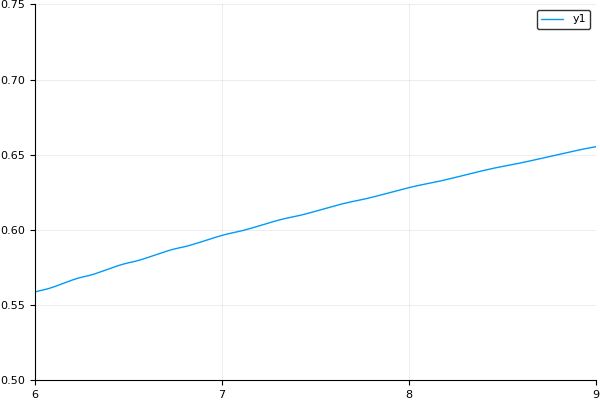

In [17]:
plot(rrm.s_vec,policy./rrm.s_vec,xlim = (6,9),ylim=(0.5,0.75))


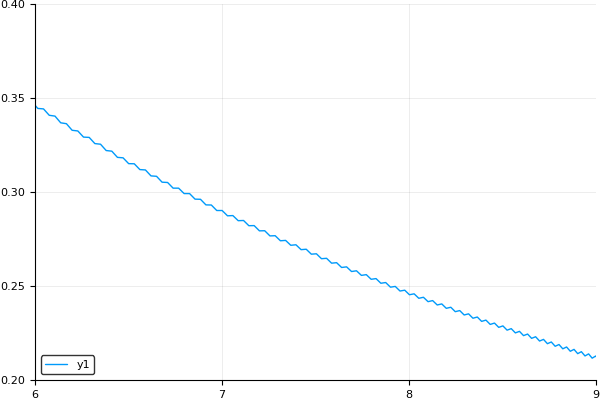

In [18]:
basis = Basis(ChebParams(n, smin, smax))
p_vec,_ = nodes(basis)
Φ = BasisMatrix(basis, Expanded(), p_vec, 0)
coeffs_V = Φ.vals[1] \ V

order = 1
B1 = evalbase(basis.params[1], p_vec, order)
interp1 = B1 * coeffs_V
plot(rrm.s_vec, interp1, xlim = (6,9),ylim=(0.2,0.4))


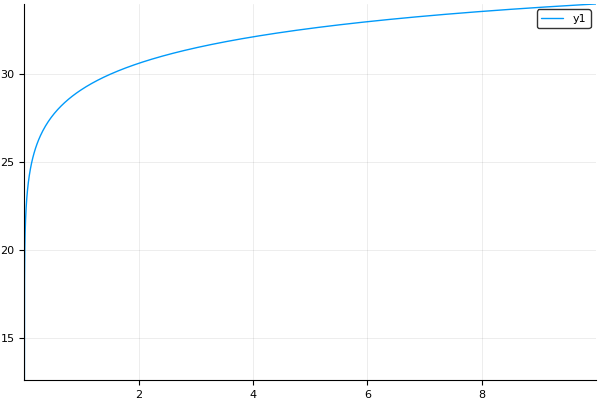

In [19]:
plot(rrm.s_vec,V)

LQモデルに当てはめる（？）

LQ  
stete vectorを$s$、control vectorを$x$、（今回は無いが）shockを$w$として、state transitionを  
\begin{eqnarray*}
s_{t+1}=As_t+Bx_t+Cw_{t+1} \\
\end{eqnarray*}
とし、目的関数  
\begin{eqnarray*}
r(s,x):=s^T_tRs_t+x^T_tQx_t+2x^T_tNs_t \\
\end{eqnarray*}
を最小化する。  

今回の例では、$r(s,x)を-f(s,x)$とし、これを最小化させる

$f(s,x)をs^*、x^*$の周りで2次までで展開すると、  
\begin{eqnarray*}
f(s,x) \simeq f(s^*,x^*)+f_s(s^*,x^*)(s-s^*)+f_x(s^*,x^*)(x-x^*)+\cfrac{1}{2}f_{ss}(s^*,x^*)(s-s^*)^2+\cfrac{1}{2}f_{xx}(s^*,x^*)(x-x^*)^2+f_{sx}(s^*,x^*)(s-s^*)(x-x^*) \\
\end{eqnarray*}

$g(s,x)をs^*、x^*$の周りで1次までで展開すると、  
\begin{eqnarray*}
g(s,x) \simeq g(s^*,x^*)+g_s(s^*,x^*)(s-s^*)+g_x(s^*,x^*)(x-x^*) \\
\end{eqnarray*}

stateを$s'=s-s^*$、actionを$x'=x-x^*$とする。
$f^*=f(s^*,x^*)$  
\begin{eqnarray*}
f(s,x) \simeq f^*+f_s^*s'+f_x^*x'+\cfrac{1}{2}f_{ss}^*s'^2+\cfrac{1}{2}f_{xx}^*x'^2+f_{sx}^*s'x' \\
\end{eqnarray*}  
\begin{eqnarray*}
=\begin{pmatrix} s' & 1 \end{pmatrix}\begin{pmatrix} \cfrac{1}{2}f^*_{ss} & \cfrac{1}{2}f^*_{s} \\  \cfrac{1}{2}f^*_{s} & f^* \end{pmatrix}\begin{pmatrix} s' \\ 1 \end{pmatrix}+\cfrac{1}{2}f^*_{xx}x'^2+2x'\begin{pmatrix} \cfrac{1}{2}f^*_{sx} & \cfrac{1}{2}f^*_x \end{pmatrix}\begin{pmatrix} s' \\ 1 \end{pmatrix}
\end{eqnarray*}  
よって
\begin{eqnarray*}
R=\begin{pmatrix} \cfrac{1}{2}f^*_{ss} & \cfrac{1}{2}f^*_{s} \\  \cfrac{1}{2}f^*_{s} & f^* \end{pmatrix}, & Q=\cfrac{1}{2}f^*_{xx}, & N=\begin{pmatrix} \cfrac{1}{2}f^*_{sx} & \cfrac{1}{2}f^*_x \end{pmatrix}
\end{eqnarray*}
また、state transiotionは
\begin{eqnarray}
g(s,x) \simeq g^*+g_s^*s'+g_x^*x' 
\end{eqnarray}
\begin{eqnarray}
\Leftrightarrow \begin{pmatrix} s'_{t+1} \\ 1 \end{pmatrix}=\begin{pmatrix} g^*_s & g^* \\  0 & 1 \end{pmatrix}\begin{pmatrix} s'_t \\ 1 \end{pmatrix}+\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}x'_t
\end{eqnarray}
よって、
\begin{eqnarray*}
A=\begin{pmatrix} g^*_s & g^* \\  0 & 1 \end{pmatrix}, & B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}
\end{eqnarray*}

lq=LQ(Q,R,A,B,C,N;bet=d)でLQのtypeを作成してstationary_values(lq)でP,F,dが出力される。  
value functionは$V(s)=\begin{pmatrix} s \\ 1 \end{pmatrix}^TP\begin{pmatrix} s \\ 1 \end{pmatrix}+d$、optimal policyは$x=-F\begin{pmatrix} s \\ 1 \end{pmatrix}$で表される。  
上記のやり方だと$s'=s-s^*$、$x'=x-x^*$とずらしてあるので、ここで元に戻すと、value functionは$V(s)=\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}^TP\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}$、optimal policyは$x=-F\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}+x^*$

~~これあってるんですかね~~

今回の例では、$y=s-x$とし、$f(s,x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x=\cfrac{(s-y)^{1-\gamma}}{1-\gamma} -\kappa (s-y)$とする。  
  
$f_{s}=(s-y)^{-\gamma}-\kappa$  
$f_{y}=-(s-y)^{-\gamma}+\kappa$  
$f_{ss}=f_{yy}=-\gamma(s-y)^{-\gamma-1}$  
$f_{sy}=\gamma(s-y)^{-\gamma-1}$  
  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2=\alpha y-0.5\beta y^2$  
$g_{s}=0$  
$g_{y}=\alpha-\beta y$

よって、今回の例では  
$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}f^*_{s} \\  -\cfrac{1}{2}f^*_{s} & -f^* \end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{yy}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f^*_{sy} & -\cfrac{1}{2}f^*_y \end{pmatrix}$  
$A=\begin{pmatrix} 0 & g^* \\  0 & 1 \end{pmatrix}$  
$B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}$  

value functionは$V(s)=\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}^TP\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}$、optimal policyは$x=-F\begin{pmatrix} s-s^* \\ 1 \end{pmatrix}+x^*$

In [20]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar
f(s,y) = ((s-y)^(1-r))/(1-r) -k*(s-y)
fs(s,y) = (s-y)^(-r) -k
fy(s,y) = -(s-y)^(-r) +k
fss(s,y) = -r*(s-y)^(-1-r)
fyy(s,y) = -r*(s-y)^(-1-r)
fsy(s,y)= r*(s-y)^(-1-r)
g(y) = a*y - 0.5*b*y^2
gy(y) = a - b*y
 
Q = -0.5*fss(sstar,ystar)
R = [-0.5*fss(sstar,ystar) -0.5*fs(sstar,ystar)
        -0.5*fs(sstar,ystar) -f(sstar,ystar)]
N = [-0.5*fsy(sstar,ystar) -0.5*fy(sstar,ystar)]
A = [0 g(ystar)
        0.0 1.0]
B = [gy(ystar); 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

QuantEcon.LQ(0.0262431197105178, [0.0262431 -0.135864; -0.135864 -3.34096], [0.0 7.38272; 0.0 1.0], [1.11111, 0.0], [0, 0], [-0.0262431 0.135864], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [21]:
P,F,d = stationary_values(lq)

([0.0 0.0; 0.0 -40.4435], [-1.0 5.17713], 0.0)

In [22]:
s0 = [6.0-sstar;1.0]
sp, up = compute_sequence(lq,s0)
stock=sp[1,:]+sstar

101-element Array{Float64,1}:
      6.0      
      7.47671  
      9.1175   
     10.9406   
     12.9663   
     15.217    
     17.7178   
     20.4965   
     23.584    
     27.0145   
     30.8261   
     35.0613   
     39.767    
      ⋮        
      1.57013e5
      1.74459e5
      1.93845e5
      2.15384e5
 239316.0      
      2.65908e5
      2.95454e5
      3.28283e5
      3.64759e5
      4.05289e5
      4.50322e5
      5.00358e5

In [23]:
up

1×100 Array{Float64,2}:
 -6.55985  -5.08314  -3.44234  -1.61924  …  3.64747e5  4.05276e5  4.50309e5

In [24]:
vlq(s) = -([s-sstar;1]'*P*[s-sstar;1] + d)

vlq (generic function with 1 method)

In [25]:
xlq(s) = -F*[s-sstar,1]

xlq (generic function with 1 method)

なんかダメみたいですね（なぜダメなのかがわからないと堂々巡りな気が）（わからない）

手法その2  
state transitionの$g(s,x)=\alpha (s-x)-0.5\beta (s-x)^2$を$f(s,x)$の中に入れ、state transitionは$s_{t+1}=s_t$として計算する

$g(s,x)=\alpha (s-x)-0.5\beta (s-x)^2$  
$f(s,x)$を$s^*,x^*$の周りで展開し、$s$に$g(s,x)$を代入する  
\begin{eqnarray*}
f(s,x) \simeq f(s^*,x^*)+f_s(s^*,x^*)(g(s,x)-s^*)+f_x(s^*,x^*)(x-x^*)+\cfrac{1}{2}f_{ss}(s^*,x^*)(g(s,x)-s^*)^2+\cfrac{1}{2}f_{xx}(s^*,x^*)(x-x^*)^2+f_{sx}(s^*,x^*)(g(s,x)-s^*)(x-x^*) \\
\end{eqnarray*}  
あれ、これほんとか？~~なんか違う気がするいや違うわこれ先に代入してちゃんとsとxわけてどうぞ~~  
いやこれでいいのか、むしろsとx分けちゃだめなんじゃないかこれ

9.7.2の例で考える。  
$y=s-x$とする。  
$g(s,x)=\alpha(s-x)-0.5\beta(s-x)^2=\alpha y-0.5\beta y^2$  
$f(s,x) =\cfrac{x^{1-\gamma}}{1-\gamma} -\kappa x=\cfrac{(g(s,x)-y)^{1-\gamma}}{1-\gamma} -\kappa (g(s,x)-y)=\cfrac{(\alpha y-0.5\beta y^2-y)^{1-\gamma}}{1-\gamma} -\kappa (\alpha y-0.5\beta y^2-y)$  
s消えましたが・・・ああこれyをsとxに戻せばいいのか？  


$f(s,x) =\cfrac{\{(\alpha-1)y-0.5\beta y^2\}^{1-\gamma}}{1-\gamma} -\kappa \{(\alpha-1)y-0.5\beta y^2\}$  
$=\cfrac{\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{1-\gamma}}{1-\gamma}-\kappa \{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}$  

$f_s(s,x)=\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}\{(\alpha-1)-\beta(s-x)\}-\kappa\{(\alpha-1)-\beta(s-x)\}$  
$f_x(s,x)=\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}\{-(\alpha-1)+\beta(s-x)\}-\kappa\{-(\alpha-1)+\beta(s-x)\}$  

$f_{ss}(s,x)=\gamma\beta s\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma-1}\{(\alpha-1)-\beta(s-x)\}-\beta\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}-\gamma\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma-1}\{(\alpha-1)-\beta(s-x)\}(\alpha-1+\beta x)+\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}+\kappa\beta$  
$=(1-\beta)\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}+\gamma\{\beta s-(\alpha-1+\beta x)\}[\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma-1}\{\alpha-1-\beta(s-x)\}]+\kappa\beta$  


$f_{xx}=(1-\beta)\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}-\gamma\{\beta x-(-\alpha+1+\beta s)\}[\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma-1}\{\alpha-1-\beta(s-x)\}]+\kappa\beta$

$f_{sx}=(1+\beta)\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma}+\gamma\{\beta x+(\alpha-1-\beta s)\}[\{(\alpha-1)(s-x)-0.5\beta(s-x)^2\}^{-\gamma-1}\{\alpha-1-\beta(s-x)\}]-\kappa\beta$

~~うっわまちがってそ～～～~~

state transitionは$s_{t+1}=s_t-x_t$となるように設定する。

よって、今回の例では  
$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}f^*_{s} \\  -\cfrac{1}{2}f^*_{s} & -f^* \end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{xx}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f^*_{sx} & -\cfrac{1}{2}f^*_x \end{pmatrix}$  
$A=\begin{pmatrix} 1 & 0 \\  0 & 1 \end{pmatrix}$  
$B=\begin{pmatrix} -1 \\ 0 \end{pmatrix}$  

In [33]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)

f(s,x) = ((a-1)*(s-x)-0.5*b*(s-x)^2)^(1-r)/(1-r) -k*((a-1)*(s-x)-0.5*b*(s-x)^2)
fs(s,x) = ((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r) *(a-1-b*(s-x)) -k*(a-1-b*(s-x))
fx(s,x) = -((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r) *(a-1-b*(s-x)) +k*(a-1-b*(s-x))
fss(s,x) = (1-b)*((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r) +r*(b*s-(a-1+b*x))*(((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r-1) *(a-1-b*(s-x))) +k*b
fxx(s,x) = (1-b)*((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r) -r*(b*x-(-a+1+b*s))*(((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r-1) *(a-1-b*(s-x))) +k*b
fsx(s,x)= (1+b)*((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r) + r*(b*x+(a-1-b*s))*(((a-1)*(s-x)-0.5*b*(s-x)^2)^(-r-1) *(a-1-b*(s-x))) -k*b
 
Q = -0.5*fss(sstar,ystar)
R = [-0.5*fss(sstar,ystar) -0.5*fs(sstar,ystar)
        -0.5*fs(sstar,ystar) -f(sstar,ystar)]
N = [-0.5*fsx(sstar,ystar) -0.5*fx(sstar,ystar)]
A = [1.0 0.0
        0.0 1.0]
B = [-1; 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

QuantEcon.LQ(-0.010391555157574187, [-0.0103916 0.25663; 0.25663 -3.00241], [1.0 0.0; 0.0 1.0], [-1, 0], [0, 0], [-0.533196 -0.25663], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [34]:
P,F,d = stationary_values(lq)

LoadError: [91mMaximum Iterations reached 51[39m

なにこれ

In [35]:
s0 = [6.0-sstar;1.0]
sp, up = compute_sequence(lq,s0)

LoadError: [91mMaximum Iterations reached 51[39m

はあ

In [39]:
lq.d

0.0

sとx分けたのがダメみたいですね、最初の例の$f(s,x)$の$s$に$g(s,x)$を代入してstate transitionを$s_{t+1}=y_t$にするだけでよさそう 

$s_{t+1}=y_t$  
$g(s)=\alpha s-0.5\beta s^2$  
$g_s(s)=\alpha-\beta s$  
$g_{ss}(s)=-\beta$

$f(s,y) =\cfrac{(g(s)-y)^{1-\gamma}}{1-\gamma} -\kappa (g(s)-y)$  

$f_s=(g(s)-y)^{-\gamma}(g_s(s))-\kappa g_s(s)$  
$f_y=-(g(s)-y)^{-\gamma}+\kappa$  


$f_{ss}=-\gamma(g(s)-y)^{-\gamma-1}(g_s(s))+(g(s)-y)^{-\gamma}(g_{ss}(s))-\kappa g_{ss}(s)$  
$f_{yy}=-\gamma(g(s)-y)^{-\gamma-1}$  
$f_{sy}=\gamma g_s(s)(g(s)-y)^{-\gamma-1}$

$f(s,x) = f(g(s),y)=$  
$f^*(g(s^*),y^*)+f_s^*(g(s^*),y^*)(g(s)-g(s^*))+f_y(g(s^*),y^*)(y-y^*)+\cfrac{1}{2}f_{ss}(g(s^*),y^*)(g(s)-g(s^*))^2+\cfrac{1}{2}f_{yy}(g(s^*),y^*)(y-y^*)^2+f_{sy}(g(s^*),y^*)(g(s)-g(s^*))(y-y^*)$

$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}f^*_{s} \\  -\cfrac{1}{2}f^*_{s} & -f^* \end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{yy}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f^*_{sy} & -\cfrac{1}{2}f^*_y \end{pmatrix}$  
$A=\begin{pmatrix} 0 & 0 \\  0 & 1 \end{pmatrix}$  
$B=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$  

In [16]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar

g(s) = a*s - 0.5*b*s^2
gs(s) = a - b*s
gss(s) = -b

f(s,y) = ((g(s)-y)^(1-r))/(1-r) -k*(g(s)-y)
fs(s,y) = (g(s)-y)^(-r) *gs(s) -k*gs(s)
fy(s,y) = -(g(s)-y)^(-r) +k
fss(s,y) = -r*(g(s)-y)^(-1-r) *gs(s) +(g(s)-y)^(-r) * gss(s) -k*gss(s)
fyy(s,y) = -r*(g(s)-y)^(-1-r)
fsy(s,y)= r*gs(s)*(g(s)-y)^(-1-r)

Q = -0.5*fyy(ystar,ystar)
R = [-0.5*fss(ystar,ystar) -0.5*fs(ystar,ystar)
        -0.5*fs(ystar,ystar) -f(ystar,ystar)]
N = [-0.5*fsy(ystar,ystar) -0.5*fy(ystar,ystar)]
A = [0 0
        0.0 1.0]
B = [1; 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

QuantEcon.LQ(0.026243119710517807, [0.165023 -0.15096; -0.15096 -3.34096], [0.0 0.0; 0.0 1.0], [1, 0], [0, 0], [-0.029159 0.135864], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [17]:
F,P,d=stationary_values(lq)

([0.16003 -0.15096; -0.15096 -33.4096], [-0.171252 -6.52038e-16], 0.0)

In [18]:
s0 = [ystar;1.0]
sp, up = compute_sequence(lq,s0)

([2.88889 0.494728 … 7.86774e-16 7.86774e-16; 1.0 1.0 … 1.0 1.0], [0.494728 0.0847231 … 7.86774e-16 7.86774e-16], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [9]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar

g(s) = a*s - 0.5*b*s^2
gs(s) = a - b*s
gss(s) = -b

f(s,y) = ((g(s)-y)^(1-r))/(1-r) -k*(g(s)-y)
fs(s,y) = (g(s)-y)^(-r) *gs(s) -k*gs(s)
fy(s,y) = -(g(s)-y)^(-r) +k
fss(s,y) = -r*(g(s)-y)^(-1-r) *gs(s) +(g(s)-y)^(-r) * gss(s) -k*gss(s)
fyy(s,y) = -r*(g(s)-y)^(-1-r)
fsy(s,y)= r*gs(s)*(g(s)-y)^(-1-r)

fsy (generic function with 1 method)

In [16]:
Q = -0.5*fyy(sstar,ystar)
R = [-0.5*fss(sstar,ystar) -0.5*fs(sstar,ystar)
        -0.5*fs(sstar,ystar) -f(sstar,ystar)]
N = [-0.5*fsy(sstar,ystar) -0.5*fy(sstar,ystar)]
A = [0 0
        0.0 1.0]
B = [1; 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

LoadError: DomainError:

なんでや

In [5]:
a,b,r,k,d = rrm.alpha, rrm.beta, rrm.gamma, rrm.kappa, rrm.delta
sstar = (a^2 - 1/(d^2))/(2*b)
xstar = sstar - (d*a - 1)/(d*b)
ystar = sstar - xstar

g(s) = a*s - 0.5*b*s^2
gs(s) = a - b*s
gss(s) = -b

f(s,y) = ((g(s)-y)^(1-r))/(1-r) -k*(g(s)-y)
fs(s,y) = (g(s)-y)^(-r) *gs(s) -k*gs(s)
fy(s,y) = -(g(s)-y)^(-r) +k
fss(s,y) = -r*(g(s)-y)^(-1-r) *gs(s) +(g(s)-y)^(-r) * gss(s) -k*gss(s)
fyy(s,y) = -r*(g(s)-y)^(-1-r)
fsy(s,y)= r*gs(s)*(g(s)-y)^(-1-r)

Q = -0.5*fyy(ystar,ystar)
R = [-0.5*fss(ystar,ystar) -0.5*fs(ystar,ystar)
        -0.5*fs(ystar,ystar) -f(ystar,ystar)]
N = [-0.5*fsy(ystar,ystar) -0.5*fy(ystar,ystar)]
A = [0 0
        0.0 1.0]
B = [1; 0]
C = [0;0]
lq = LQ(Q,R,A,B,C,N;bet=d)

QuantEcon.LQ(0.026243119710517807, [0.165023 -0.15096; -0.15096 -3.34096], [0.0 0.0; 0.0 1.0], [1, 0], [0, 0], [-0.029159 0.135864], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [6]:
P,F,d = stationary_values(lq)

([0.16003 -0.15096; -0.15096 -33.4096], [-0.171252 -6.52038e-16], 0.0)

In [7]:
s0 = [ystar;1.0]
sp, up = compute_sequence(lq,s0)

([2.88889 0.494728 … 7.86774e-16 7.86774e-16; 1.0 1.0 … 1.0 1.0], [0.494728 0.0847231 … 7.86774e-16 7.86774e-16], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [8]:
up

1×100 Array{Float64,2}:
 0.494728  0.0847231  0.014509  0.00248469  …  7.86774e-16  7.86774e-16

In [9]:
sp[1,:]

101-element Array{Float64,1}:
 2.88889    
 0.494728   
 0.0847231  
 0.014509   
 0.00248469 
 0.000425509
 7.28692e-5 
 1.2479e-5  
 2.13705e-6 
 3.65974e-7 
 6.26738e-8 
 1.0733e-8  
 1.83805e-9 
 ⋮          
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16
 7.86774e-16

In [10]:
g

g (generic function with 1 method)

In [15]:
g(ystar)

7.382716049382715

In [13]:
ystar

2.8888888888888884

In [14]:
sstar

7.382716049382716

そもそもこの手法自体どうなんですかね？

$f(s,x)=log(s^\alpha-x)$  
$g(s,x)=x$   
の例で確認

In [5]:
a = 0.5
d3  = 0.9
xstar = (d3*a)^(1/(1-a))
sstar = xstar


g3(s,x) = x
g3s(s,x) = 0
g3x(s,x) = 1

f3(s,x) = log(s^a-x)
f3s(s,x) = (a*s^(a-1))/(s^a-x)
f3x(s,x) = (-1)/(s^a-x)
f3ss(s,x) = ((a*(a-1)*s^(a-2))*(s^a-x)-(a*s^(a-1))*(a*s^(a-1)))/((s^a-x)^2)
f3xx(s,x) = (-1)/((s^a-x)^2)
f3sx(s,x)= (a*s^(a-1))/(s^a-x)^2

Q3 = -0.5*f3xx(sstar,xstar)
R3 = [-0.5*f3ss(sstar,xstar) -0.5*f3s(sstar,xstar)
        -0.5*f3s(sstar,xstar) -f3(sstar,xstar)]
N3 = [-0.5*f3sx(sstar,xstar) -0.5*f3x(sstar,xstar)]
A3 = [g3s(sstar,xstar) g3(sstar,xstar)
        0.0 1.0]
B3 = [g3x(sstar,xstar); 0]
C3 = [0;0]
lq3 = LQ(Q3,R3,A3,B3,C3,N3;bet=d3)

QuantEcon.LQ(8.162432404856647, [15.6195 -2.24467; -2.24467 1.39634], [0.0 0.2025; 0.0 1.0], [1, 0], [0, 0], [-9.06937 2.0202], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [6]:
P3,F3,D3=stationary_values(lq3)

([11.0848 -0.408122; -0.408122 9.12874], [-0.5 0.2025], 0.0)

In [7]:
V(s)= -([s;1]'*P3*[s;1] +D3)

V (generic function with 1 method)

In [8]:
V(sstar)

-9.417992424279367

In [9]:
f3(sstar,xstar)

-1.3963446969733921

なんでこの二つ一致しないんですかね・・・  
stateとcontrolをずらしてるからいけない説があるのでずらさない方法で試して、どうぞ

$f(s,x) \simeq f(s^*,x^*)+f_s(s^*,x^*)(s-s^*)+f_x(s^*,x^*)(x-x^*)+\cfrac{1}{2}f_{ss}(s^*,x^*)(s-s^*)^2+\cfrac{1}{2}f_{xx}(s^*,x^*)(x-x^*)^2+f_{sx}(s^*,x^*)(s-s^*)(x-x^*)$

$f^*=f(s^*,x^*)$とする

$f(s,x) \simeq f^*+f_s^*(s-s^*)+f_x^*(x-x^*)+\cfrac{1}{2}f_{ss}^*(s-s^*)^2+\cfrac{1}{2}f_{xx}^*(x-x^*)^2+f_{sx}^*(s-s^*)(x-x^*)$

$=\cfrac{1}{2}f_{ss}^*s^2+(f_s^*-f_{ss}^*s^*-f_{sx}x^*)s$  
$+\cfrac{1}{2}f_{xx}^*x^2+(f_x^*-f_{xx}^*x^*-f_{sx}s^*)x$  
$+f_{sx}^*sx$  
$+f^*-f_s^*s^*-f_x^*x^*+\cfrac{1}{2}f_{ss}^*s^{*2}+\cfrac{1}{2}f_{xx}^*x^{*2}+f_{sx}s^*x^*$

係数比較して、  
$R=\begin{pmatrix} -\cfrac{1}{2}f^*_{ss} & -\cfrac{1}{2}(f_s^*-f_{ss}^*s^*-f_{sx}^*x^*) \\  -\cfrac{1}{2}(f_s^*-f_{ss}^*s^*-f_{sx}^*x^*) & -(f^*-f_s^*s^*-f_x^*x^*+\cfrac{1}{2}f_{ss}^*s^{*2}+\cfrac{1}{2}f_{xx}^*x^{*2}+f_{sx}^*s^*x^*) \end{pmatrix}$  
$Q=-\cfrac{1}{2}f^*_{ss}$  
$N=\begin{pmatrix} -\cfrac{1}{2}f_{sx}^* & -\cfrac{1}{2}(f_x^*-f_{xx}^*x^*-f_{sx}^*s^*) \end{pmatrix}$  
$A=\begin{pmatrix} g^*_s & g^* \\  0 & 1 \end{pmatrix}$  
$B=\begin{pmatrix} g^*_x \\ 0 \end{pmatrix}$  

In [11]:
a = 0.5
d4  = 0.9
xstar = (d4*a)^(1/(1-a))
sstar = xstar


g4(s,x) = x
g4s(s,x) = 0
g4x(s,x) = 1

f4(s,x) = log(s^a-x)
f4s(s,x) = (a*s^(a-1))/(s^a-x)
f4x(s,x) = (-1)/(s^a-x)
f4ss(s,x) = ((a*(a-1)*s^(a-2))*(s^a-x)-(a*s^(a-1))*(a*s^(a-1)))/((s^a-x)^2)
f4xx(s,x) = (-1)/((s^a-x)^2)
f4sx(s,x)= (a*s^(a-1))/(s^a-x)^2

Q4 = -0.5*f4xx(sstar,xstar)
R4 = [-0.5*f4ss(sstar,xstar) -0.5*(f4s(sstar,xstar)-f4ss(sstar,xstar)*sstar-f4sx(sstar,xstar)*xstar)
        -0.5*(f4s(sstar,xstar)-f4ss(sstar,xstar)*sstar-f4sx(sstar,xstar)*xstar) -(f4(sstar,xstar)-f4s(sstar,xstar)*sstar-f4x(sstar,xstar)*xstar+0.5*f4ss(sstar,xstar)*sstar^2+0.5*f4xx(sstar,xstar)*xstar^2+f4sx(sstar,xstar)*sstar*xstar)]
N4 = [-0.5*f4sx(sstar,xstar) -0.5*(f4x(sstar,xstar)-f4xx(sstar,xstar)*xstar-f4sx(sstar,xstar)*sstar)]
A4 = [g4s(sstar,xstar) g4(sstar,xstar)
        0.0 1.0]
B4 = [g4x(sstar,xstar); 0]
C4 = [0;0]
lq4 = LQ(Q4,R4,A4,B4,C4,N4;bet=d4)

QuantEcon.LQ(8.162432404856647, [15.6195 -3.57106; -3.57106 1.71866], [0.0 0.2025; 0.0 1.0], [1, 0], [0, 0], [-9.06937 2.20386], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [12]:
P4,F4,D4=stationary_values(lq4)

([11.0848 -2.65279; -2.65279 9.74857], [-0.5 0.10125], 0.0)

In [13]:
V4(s)= -([s;1]'*P4*[s;1] +D4)

V4 (generic function with 1 method)

In [17]:
V4(sstar)

-9.128736225932258

In [15]:
f4(sstar,xstar)

-1.3963446969733921

In [18]:
function lqapprox(f,fs,fx,fss,fxx,fsx,g,gs,gx,sstar,xstar,d)
    fstar = f(sstar,xstar)
    s = fs(sstar,xstar)
    ss = fss(sstar,xstar)
    x = fx(sstar,xstar)
    xx = fxx(sstar,xstar)
    sx = fsx(sstar,xstar)
    Q = -0.5*xx
    R = [-0.5*ss -0.5*(s-ss*sstar-sx*xstar)
            -0.5*(s-ss*sstar-sx*xstar) -(fstar-s*sstar-x*xstar+0.5*ss*sstar^2+0.5*xx*xstar^2+sx*sstar*xstar)]
    N = [-0.5*sx -0.5*(x-xx*xstar-sx*sstar)]
    A = [gs(sstar,xstar) g(sstar,xstar)
            0.0 1.0]
    B = [gx(sstar,xstar); 0]
    C = [0;0]
    lq = LQ(Q,R,A,B,C,N;bet=d)
    
    return lq
end

lqapprox (generic function with 1 method)

In [19]:
a = 0.5
d4  = 0.9
xstar = (d4*a)^(1/(1-a))
sstar = xstar

g4(s,x) = x
g4s(s,x) = 0
g4x(s,x) = 1

f4(s,x) = log(s^a-x)
f4s(s,x) = (a*s^(a-1))/(s^a-x)
f4x(s,x) = (-1)/(s^a-x)
f4ss(s,x) = ((a*(a-1)*s^(a-2))*(s^a-x)-(a*s^(a-1))*(a*s^(a-1)))/((s^a-x)^2)
f4xx(s,x) = (-1)/((s^a-x)^2)
f4sx(s,x)= (a*s^(a-1))/(s^a-x)^2

f4sx (generic function with 1 method)

In [21]:
lq4=lqapprox(f4,f4s,f4x,f4ss,f4xx,f4sx,g4,g4s,g4x,sstar,xstar,d4)

QuantEcon.LQ(8.162432404856647, [15.6195 -3.57106; -3.57106 1.71866], [0.0 0.2025; 0.0 1.0], [1, 0], [0, 0], [-9.06937 2.20386], 0.9, nothing, [NaN NaN; NaN NaN], [NaN NaN; NaN NaN], 0.0, [0.0 0.0])

In [22]:
P4,F4,D4=stationary_values(lq4)

([11.0848 -2.65279; -2.65279 9.74857], [-0.5 0.10125], 0.0)

In [23]:
V4(s)= -([s;1]'*P4*[s;1] +D4)

V4 (generic function with 1 method)

In [24]:
V4(sstar)

-9.128736225932258

In [25]:
f4(sstar,xstar)

-1.3963446969733921

In [28]:
s0 = [0;1.0]
sp4, up4 = compute_sequence(lq4,s0)

([0.0 0.10125 … 0.2025 0.2025; 1.0 1.0 … 1.0 1.0], [-0.10125 -0.050625 … 6.93889e-17 6.93889e-17], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [30]:
up4

1×100 Array{Float64,2}:
 -0.10125  -0.050625  -0.0253125  -0.0126562  …  6.93889e-17  6.93889e-17